In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [3]:
with np.load(fname) as dobj:
    dat = dict(**dobj)

labels_dnn = np.load('kay_labels.npy')

responses = dat["responses"]

In [ ]:
print(np.max(dat['stimuli']))
print(np.max(dat['stimuli'][1,:,:]))

0.4644977
0.4644977


### First, calculate the contrast value for each image. We are going to base this calculation in the co-ocurrence matrix, where each element is the number of ocurrences according to vecinity rules (e.g. up, down, left, right, in certain angle). The contrast value increases as the element is further away from the diagonal in the co-ocurrence matrix.

In [259]:
import cv2 

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow
from skimage import feature

contrast_values = np.zeros(len(dat['stimuli']))
contrast_RMS = np.zeros(len(dat['stimuli']))

for idx in range(len(dat['stimuli'])):
  imag = dat['stimuli'][idx,:,:]

  # Normalize the image values from float to unit in the range 0 - 255
  I = cv2.normalize(imag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
  # Normalize the image values from float to unit in the range 0 - 1
  I_norm = cv2.normalize(imag, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8U)

  # Calculate the co-ocurrence matrix 
  co_oc_matrix = feature.greycomatrix(I, distances=[1], angles=[0], levels=256, symmetric=False, normed=False)
  
  # Obtain the contrast values from that calculated matrix
  contrast_values[idx] = feature.greycoprops(co_oc_matrix, 'contrast') 
# Contrast returns a measure of the intensity contrast between a pixel and its neighbor over the whole image.
#  Range = [0 (size(GLCM,1)-1)^2] 

  # Additionaly, calculate the RMS contrast (not very recommended)
  contrast_RMS[idx] = I_norm.std()

print(np.max(contrast_values),np.min(contrast_values))
print(np.max(contrast_RMS),np.min(contrast_RMS))

contrast_values[contrast_values<=473] = 0
contrast_values[(contrast_values>473) & (contrast_values<=934)] = 1
contrast_values[(contrast_values>934) & (contrast_values<=1395)] = 2
contrast_values[contrast_values>1395] = 3

contrast_RMS[contrast_RMS<=0.18] = 0
contrast_RMS[(contrast_RMS>0.18) & (contrast_RMS<=0.28)] = 1
contrast_RMS[(contrast_RMS>0.28) & (contrast_RMS<=0.38)] = 2
contrast_RMS[contrast_RMS>0.38] = 3

print(sum(float(num) == 0 for num in contrast_values)) # low contrast
print(sum(float(num) == 1 for num in contrast_values)) # medium contrast
print(sum(float(num) == 2 for num in contrast_values)) # high contrast
print(sum(float(num) == 3 for num in contrast_values)) # very high contrast


print(sum(float(num) == 0 for num in contrast_RMS))
print(sum(float(num) == 1 for num in contrast_RMS))
print(sum(float(num) == 2 for num in contrast_RMS))
print(sum(float(num) == 3 for num in contrast_RMS))

1846.0617002952758 12.391363188976376
0.5 0.08631896837789808
1472
249
19
10
7
0
0
1743


contrast RMS: 0.48304858793361843
[[1846.0617003]]


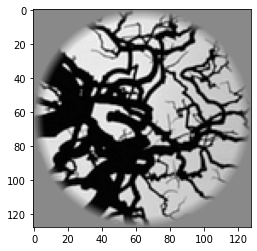

In [249]:
import cv2 

from PIL import Image, ImageStat
from matplotlib.pyplot import imshow
from skimage import feature

imag = dat["stimuli"][495,:,:]

I = cv2.normalize(imag, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

I_norm = cv2.normalize(imag, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8U)

print('contrast RMS:',I_norm.std())
imshow(I, cmap='gray')

co_oc_matrix = feature.greycomatrix(I, distances=[1], angles=[0], levels=256, symmetric=False, normed=False)
image_contrast = feature.greycoprops(co_oc_matrix, 'contrast') 
print(image_contrast)
# Contrast returns a measure of the intensity contrast between a pixel and its neighbor over the whole image.
#  Range = [0 (size(GLCM,1)-1)^2] 

# Now, correlate those contrast values with the voxel activations

In [271]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=8, random_state=2020, method='exact') 

In [272]:
embed = tsne_model.fit_transform(responses)
print(embed.shape)

(1750, 2)


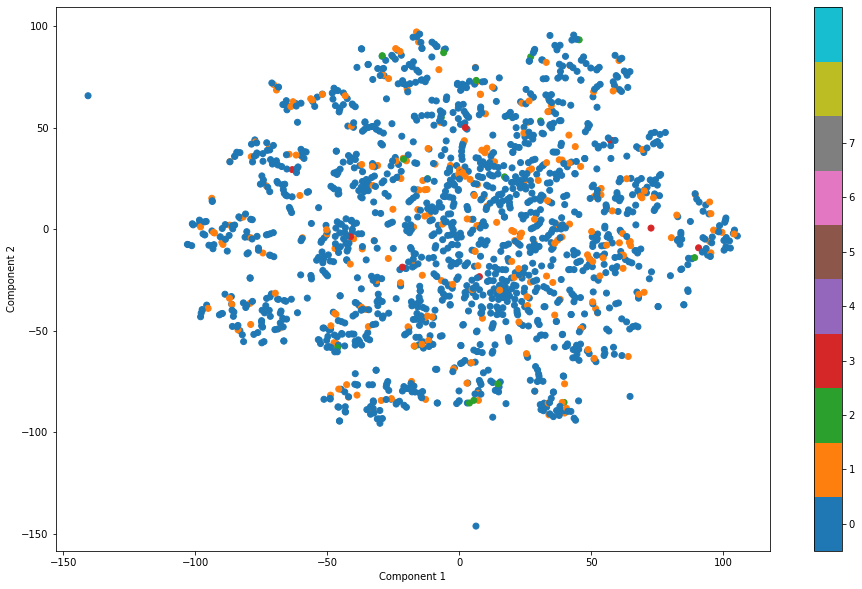

In [273]:
plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(x=embed[:,0], y=embed[:,1], c=contrast_values,cmap=cmap)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(ticks=range(8))
plt.clim(-0.5, 9.5)
plt.show()